<a href="https://colab.research.google.com/github/marcinwolter/MachineLearnin2019/blob/master/cross_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross-validation for parameter tuning, model selection, and feature selection
*From the video series: [Introduction to machine learning with scikit-learn](https://github.com/justmarkham/scikit-learn-videos)*

Modified by Marcin Wolter

## Agenda

- What is the drawback of using the **train/test split** procedure for model evaluation?
- How does **K-fold cross-validation** overcome this limitation?
- How can cross-validation be used for selecting **tuning parameters**, choosing between **models**, and selecting **features**?

## Review of model evaluation procedures

**Motivation:** Need a way to choose between machine learning models

- Goal is to estimate likely performance of a model on **out-of-sample data**

**Initial idea:** Train and test on the same data

- But, maximizing **training accuracy** rewards overly complex models which **overfit** the training data

**Alternative idea:** Train/test split

- Split the dataset into two pieces, so that the model can be trained and tested on **different data**
- **Testing accuracy** is a better estimate than training accuracy of out-of-sample performance
- But, it provides a **high variance** estimate since changing which observations happen to be in the testing set can significantly change testing accuracy

In [0]:
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.datasets import make_moons, make_circles
from sklearn.preprocessing import StandardScaler



import numpy as np

In [0]:
# read in the iris data
#iris = load_iris()

# create X (features) and y (response)
#X = iris.data
#y = iris.target

In [0]:
# prepare "moons"/"circles" 2D dataset
   
X, y = make_moons(n_samples=500, noise=0.3, random_state=0)
#X, y = make_circles(n_samples=500, noise=0.5, factor=0.5, random_state=1)
X = StandardScaler().fit_transform(X)
    

In [4]:
# use train/test split with different random_state values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)

# check classification accuracy of KNN with K=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.864


**Question:** What if we created a bunch of train/test splits, calculated the testing accuracy for each, and averaged the results together?

**Answer:** That's the essense of cross-validation!

## Steps for K-fold cross-validation

1. Split the dataset into K **equal** partitions (or "folds").
2. Use fold 1 as the **testing set** and the union of the other folds as the **training set**.
3. Calculate **testing accuracy**.
4. Repeat steps 2 and 3 K times, using a **different fold** as the testing set each time.
5. Use the **average testing accuracy** as the estimate of out-of-sample accuracy.

Diagram of **5-fold cross-validation:**

![5-fold cross-validation](https://github.com/marcinwolter/MachineLearnin2019/blob/master/images/07_cross_validation_diagram.png?raw=1)

In [5]:
# simulate splitting a dataset of 25 observations into 5 folds
from sklearn.model_selection import KFold
kf = KFold( n_splits=5, shuffle=False)

# print the contents of each training and testing set
print('{} {:^61} {}'.format('Iteration', 'Training set observations', 'Testing set observations'))
for iteration, data in enumerate(kf.split(X_train, y_train), start=1):
    print('{:^9} {} {:^25}'.format(iteration, data[0], data[1]))

Iteration                   Training set observations                   Testing set observations
    1     [ 75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254
 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272
 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290
 291 292 293 294 

- Dataset contains **25 observations** (numbered 0 through 24)
- 5-fold cross-validation, thus it runs for **5 iterations**
- For each iteration, every observation is either in the training set or the testing set, **but not both**
- Every observation is in the testing set **exactly once**

## Comparing cross-validation to train/test split

Advantages of **cross-validation:**

- More accurate estimate of out-of-sample accuracy
- More "efficient" use of data (every observation is used for both training and testing)

Advantages of **train/test split:**

- Runs K times faster than K-fold cross-validation
- Simpler to examine the detailed results of the testing process

## Cross-validation recommendations

1. K can be any number, but **K=10** is generally recommended
2. For classification problems, **stratified sampling** is recommended for creating the folds
    - Each response class should be represented with equal proportions in each of the K folds
    - scikit-learn's `cross_val_score` function does this by default

## Cross-validation example: parameter tuning

**Goal:** Select the best tuning parameters (aka "hyperparameters") for KNN on the iris dataset

In [0]:
from sklearn.model_selection import cross_val_score

In [23]:
# 10-fold cross-validation with K=3 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print(scores)

[0.9  0.9  0.8  0.86 0.86 0.88 0.84 0.96 0.9  0.9 ]


In [17]:
# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

0.8800000000000001


In [29]:
# search for an optimal value of K for KNN
k_range = list(range(1, 101))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.8816666666666667, 0.8533333333333333, 0.8733333333333333, 0.8758333333333335, 0.8808333333333332, 0.885, 0.8941666666666666, 0.8966666666666667, 0.9008333333333333, 0.9008333333333334, 0.9041666666666666, 0.9058333333333333, 0.9008333333333333, 0.9025, 0.9, 0.8966666666666667, 0.8958333333333335, 0.8991666666666667, 0.8975, 0.8966666666666667, 0.8991666666666667, 0.8975, 0.8958333333333335, 0.8941666666666667, 0.8925, 0.8941666666666667, 0.8916666666666667, 0.8941666666666667, 0.8958333333333335, 0.8941666666666667, 0.895, 0.8983333333333334, 0.9, 0.8966666666666667, 0.8983333333333333, 0.8983333333333334, 0.8958333333333335, 0.8983333333333334, 0.8941666666666667, 0.8941666666666667, 0.895, 0.8933333333333334, 0.8966666666666666, 0.895, 0.895, 0.8925, 0.895, 0.8933333333333334, 0.8966666666666666, 0.895, 0.8966666666666666, 0.8975, 0.895, 0.8958333333333335, 0.8983333333333334, 0.8966666666666666, 0.8966666666666666, 0.8941666666666666, 0.8983333333333334, 0.8941666666666666, 0.895

Text(0,0.5,'Cross-Validated Accuracy')

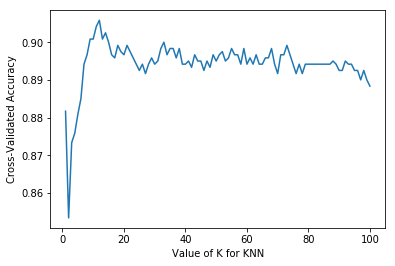

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

# **And now optimization with HYPEROPT**

In [11]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

def hyperopt_train_test(params):
    clf = KNeighborsClassifier(**params)
    return cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean()

space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(1,101))
}

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=100, trials=trials)
print 'best:'
print best

100%|██████████| 100/100 [00:04<00:00, 22.46it/s, best loss: -0.9]
best:
{'n_neighbors': 12}
